In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rcParams.update({'font.size': 14})

transaction_fname = "train_transaction.csv"
id_fname = "train_identity.csv"
path_to_dataset = "C:\\Users\\verdi\\Documents\\Datasets\\IEEEFraudDetection\\ieee-fraud-detection\\"
transaction_df = pd.read_csv(path_to_dataset + transaction_fname)
identity_df = pd.read_csv(path_to_dataset + id_fname)
train_df = transaction_df.merge(identity_df, how="left", on="TransactionID")
train_df.head(5)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [3]:
def savefig(fig, fname):
    for ftype in ["png", "svg", "pdf"]:
        fig.savefig(f"./export/graph/{fname}.{ftype}")


In [4]:
# On calcule quelques informations de base:
# - nombre d'observations;
# - nombre de variables;
# - nombre de classes (devrait être seulement deux mais on vérifie);
# - ratio entre les classes;
num_classes = len(train_df.loc[:, "isFraud"].unique())
anomaly_ratio = len(train_df[train_df["isFraud"] == 1]) / train_df.shape[0]

basic_infos = [[train_df.shape[0], train_df.shape[1], anomaly_ratio]]
df_info = pd.DataFrame(
    basic_infos,
    columns=["Nombre d'observations", "Nombre de variables", "Ratio d'anomalie"]
)
assert num_classes == 2, "Les données contiennent plus de deux classes"
df_info

,Nombre d'observations,Nombre de variables,Ratio d'anomalie
0,590540,434,0.03499


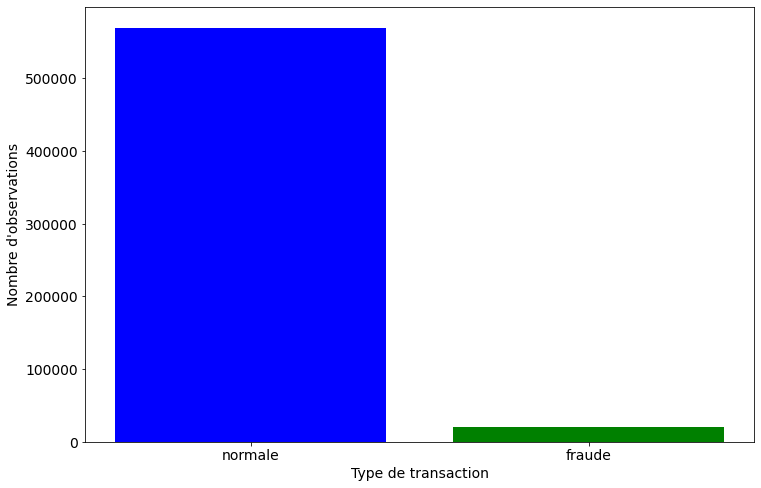

In [5]:
# On affiche le débalancement de classe
count_df = train_df.groupby("isFraud")["isFraud"].count()

f, ax = plt.subplots(figsize=(12,8))
ax.set_xticks([0, 1])
ax.set_ylabel("Nombre d'observations")
ax.set_xlabel("Type de transaction")

ax.bar(["normale", "fraude"], count_df, color=["blue", "green"])
plt.show()
savefig(f, "class_imbalance")

## Affichage des transactions journalières

In [6]:
train_df["day"] = (train_df["TransactionDT"] // (3600 * 24) - 1) % 7


day_counts = train_df.groupby("day").size().to_numpy()
day_pct = (day_counts / day_counts.sum()) * 100
days = train_df["day"].unique()
colors = ("blue", "orange", "pink", "green", "red", "purple", "brown", "pink")

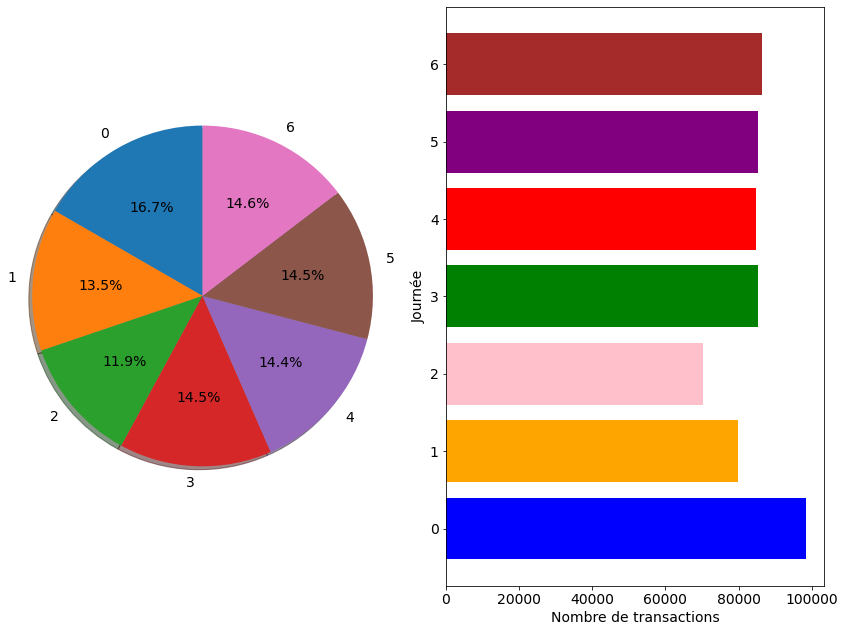

In [7]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 9))
f.subplots_adjust(top=2)

# Pourcentage
axs[0].pie(day_pct, labels=days, autopct='%1.1f%%', shadow=True, startangle=90)
axs[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Décompte par jour
axs[1].barh(y=days, width=day_counts, color=colors)
axs[1].set_xlabel("Nombre de transactions")
axs[1].set_ylabel("Journée")

plt.tight_layout()
savefig(f, "transactions_per_day")
plt.show()

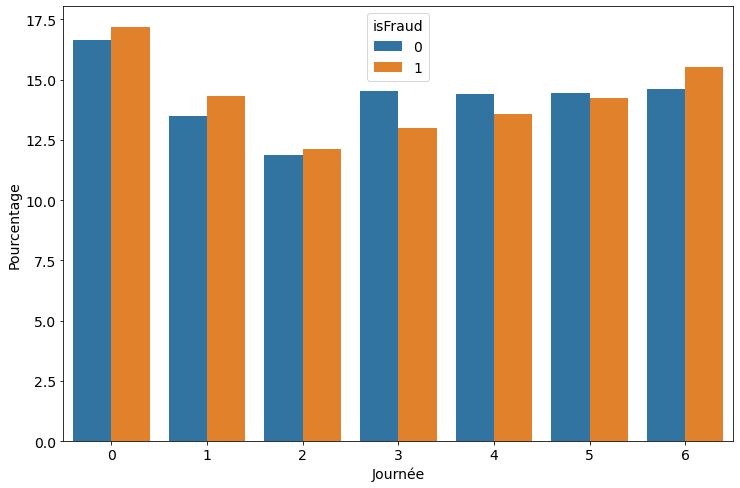

In [8]:
train_day = (train_df.groupby(['isFraud'])['day']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('day'))

f, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x="day", y="percentage", hue="isFraud", data=train_day, ax=ax)
ax.set_xlabel("Journée")
ax.set_ylabel("Pourcentage")
savefig(f, "frauds_per_day")

## Analyse pour les produits

In [9]:
assert train_df['ProductCD'].isnull().sum() == 0, "Certaines transactions ne sont pas associées à un produit"
train_df['ProductCD'].value_counts()

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

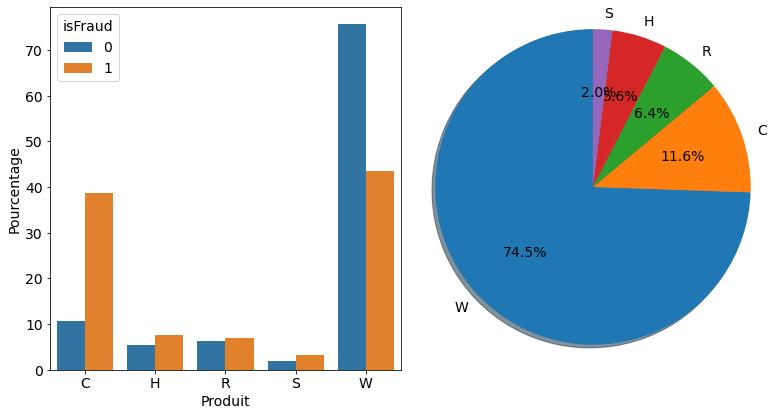

In [10]:
products = train_df['ProductCD'].value_counts().index.to_numpy()
product_counts = train_df['ProductCD'].value_counts().to_numpy()
product_pct = (product_counts / product_counts.sum()) * 100

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,6))

product_df = (train_df.groupby(['isFraud'])['ProductCD']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('ProductCD'))


# Décompte par jour
sns.barplot(x="ProductCD", y="percentage", hue="isFraud", data=product_df, ax=axs[0])
axs[0].set_xlabel("Produit")
axs[0].set_ylabel("Pourcentage")

# Pourcentage
axs[1].pie(product_pct, labels=products, autopct="%1.1f%%", shadow=True, startangle=90)
axs[1].axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

# Affichage
plt.tight_layout()
savefig(f, "frauds_per_product")
plt.show()


## Analyse pour les cartes

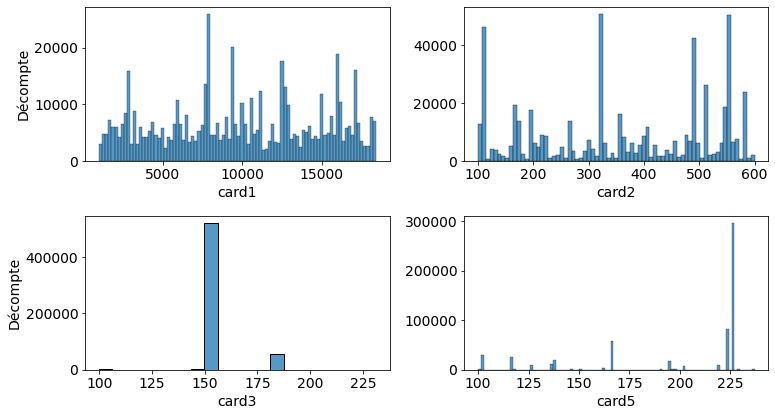

In [11]:
cards = [col for col in train_df.columns if 'card' in col]

# Histogramme pour chaque attribut
num_cards = [c for c in cards if train_df[c].dtypes != "object" ]
num_cards

f, axs = plt.subplots(nrows=2, ncols=2, figsize=(11,6))
cnt = 0
for row in axs:
    for ax in row:
        col = num_cards[cnt]
        sns.histplot(x=train_df[col], ax=ax)
        cnt += 1
        ax.set_xlabel(col)

axs[0, 0].set_ylabel("Décompte")
axs[1, 0].set_ylabel("Décompte")
axs[0, 1].set_ylabel("")
axs[1, 1].set_ylabel("")

savefig(f, "card_attributes_histograms")
plt.tight_layout()

C:\Users\verdi\.conda\envs\anomaly_detection\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\verdi\.conda\envs\anomaly_detection\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


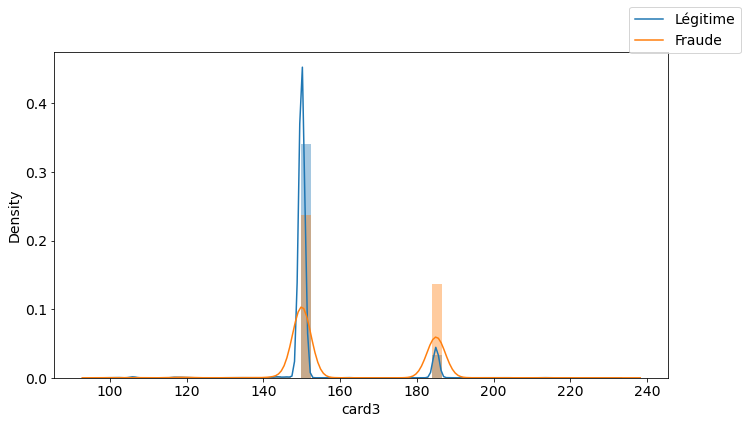

In [12]:
# Densité en fonction de la classe
f = plt.figure(figsize=(11, 6))
sns.distplot(train_df[(train_df['isFraud']==0) & (~train_df['card3'].isnull())]['card3'])
sns.distplot(train_df[(train_df['isFraud']==1) & (~train_df['card3'].isnull())]['card3'])
f.legend(["Légitime", "Fraude"])

savefig(f, "card3_density")



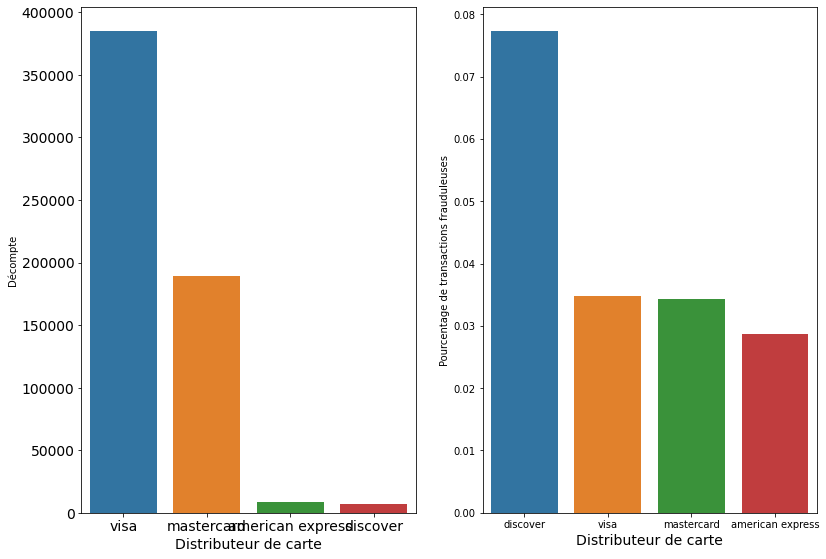

In [13]:
# idea from https://www.kaggle.com/gpreda/home-credit-default-risk-extensive-eda
def hor_plot(feat, df=train_df, label_rotation=False, shape=(12,8), xlabel=None):
    val_cnts = df[feat].value_counts()
    df1 = pd.DataFrame({feat: val_cnts.index,'Number of units': val_cnts.values})
    # Calculate the percentage of target=1 per category value. For that what we did is we took the mean value of TARGET
    percent = df[[feat, 'isFraud']].groupby([feat],as_index=False).mean()
    percent.sort_values(by='isFraud', ascending=False, inplace=True)
    f, (ax1, ax2) = plt.subplots(ncols=2, figsize=shape)
    s = sns.barplot(ax=ax1, x=feat, y="Number of units", data=df1)
    if label_rotation:
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    
    s = sns.barplot(ax=ax2, x=feat, y="isFraud", order=percent[feat], data=percent)
    if label_rotation:
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    ax1.set_xlabel(xlabel or feat)
    ax2.set_xlabel(xlabel or feat)
    ax1.set_ylabel("Décompte", fontsize=10)
    ax2.set_ylabel("Pourcentage de transactions frauduleuses", fontsize=10)
    plt.tight_layout()
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.show()
    return f

f = hor_plot("card4", xlabel="Distributeur de carte")
savefig(f, "card_distributor_fraud")


## Domaine de email

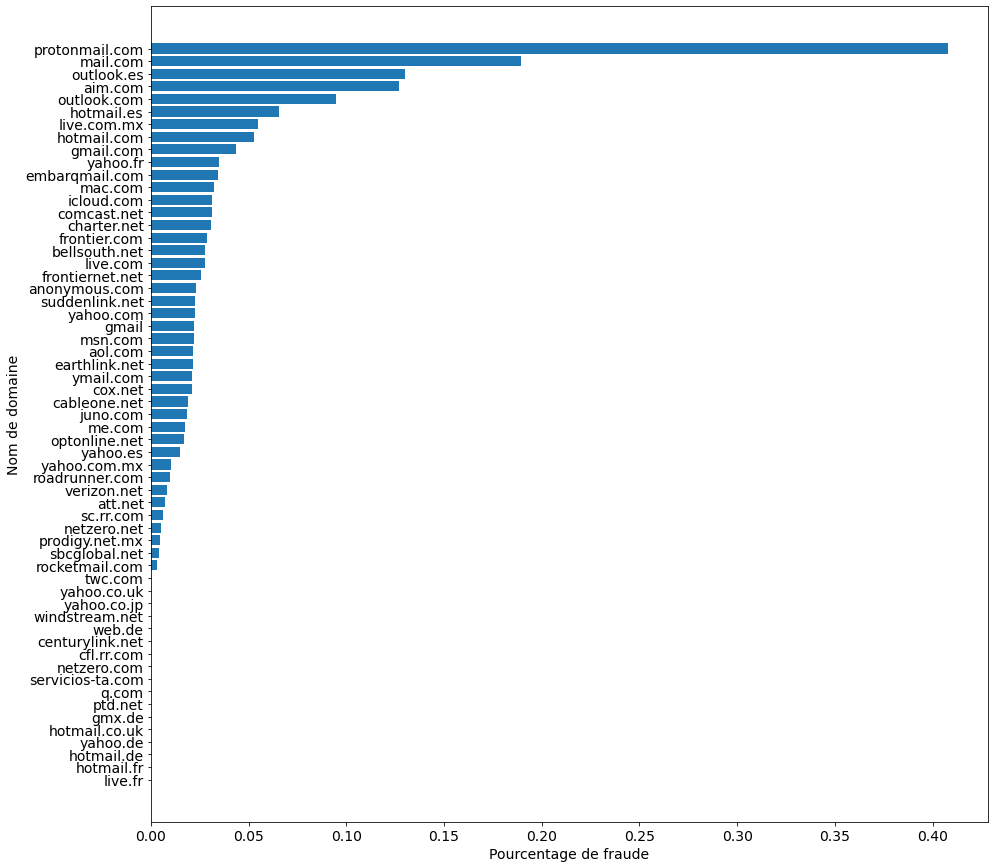

In [14]:
train_df['P_emaildomain'].value_counts()[:10]

f, ax = plt.subplots(figsize=(15, 15))

sorted_df = train_df[['P_emaildomain','isFraud']].groupby(by=['P_emaildomain']).mean().sort_values(by=['isFraud'])
ax.barh(y=sorted_df.index.to_numpy(), width=sorted_df["isFraud"].to_numpy())
ax.set_xlabel("Pourcentage de fraude")
ax.set_ylabel("Nom de domaine")

savefig(f, "email_domain_fraud")
plt.show()


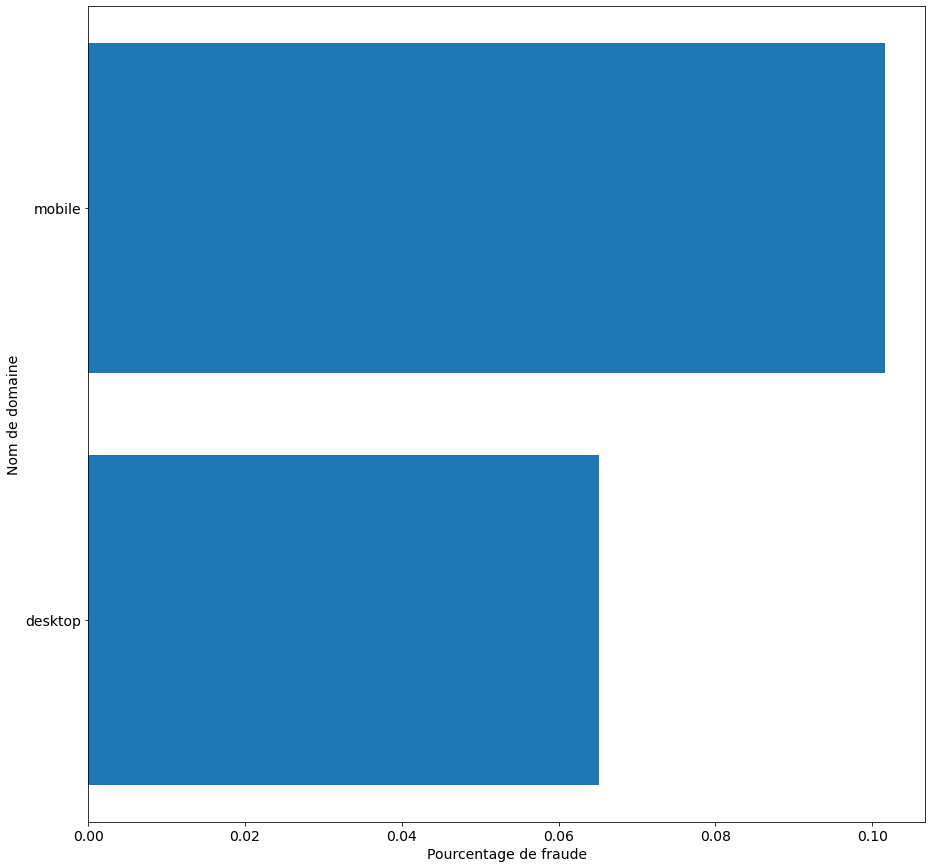

In [15]:
train_df['DeviceType'].value_counts()[:10]

f, ax = plt.subplots(figsize=(15, 15))

sorted_df = train_df[['DeviceType', 'isFraud']].groupby(by=['DeviceType']).mean().sort_values(by=['isFraud'])
ax.barh(y=sorted_df.index.to_numpy(), width=sorted_df["isFraud"].to_numpy())
ax.set_xlabel("Pourcentage de fraude")
ax.set_ylabel("Nom de domaine")

#savefig(f, "device_type_fraud")
plt.show()


In [16]:
def fraud_graph(df, col, ylabel):
    df[col].value_counts()[:10]
    f, ax = plt.subplots(figsize=(15, 15))

    sorted_df = df[[col, "isFraud"]].groupby(by=[col]).mean().sort_values(by=["isFraud"])
    ax.barh(y=sorted_df.index.to_numpy(), width=sorted_df["isFraud"].to_numpy())
    ax.set_xlabel("Pourcentage de fraude")
    ax.set_ylabel(ylabel)

    #savefig(f, "device_type_fraud")
    plt.show()


In [17]:
def id_split(dataframe):
    dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0].str.split(' ', expand=True)[0]
    dataframe.loc[dataframe['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    dataframe.loc[dataframe['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    dataframe.loc[dataframe['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    dataframe.loc[dataframe['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    dataframe.loc[dataframe['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    dataframe.loc[dataframe['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    dataframe.loc[dataframe.device_name.isin(dataframe.device_name.value_counts()[dataframe.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    
    return dataframe

In [18]:
train_df = id_split(train_df)
#train_df.columns
#train_df['DeviceInfo'].str.split('/', expand=True)[0].str.split(' ', expand=True)[0]
#fraud_graph(train_df, "device_name", "DeviceInfo")

In [19]:
train_df["DeviceInfo"] = train_df["DeviceInfo"].fillna("None")
id_split(train_df)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,day,device_name
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0,None
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0,None
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0,None
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0,None
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0,Samsung
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,6,None
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,6,None
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,6,None
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,6,None


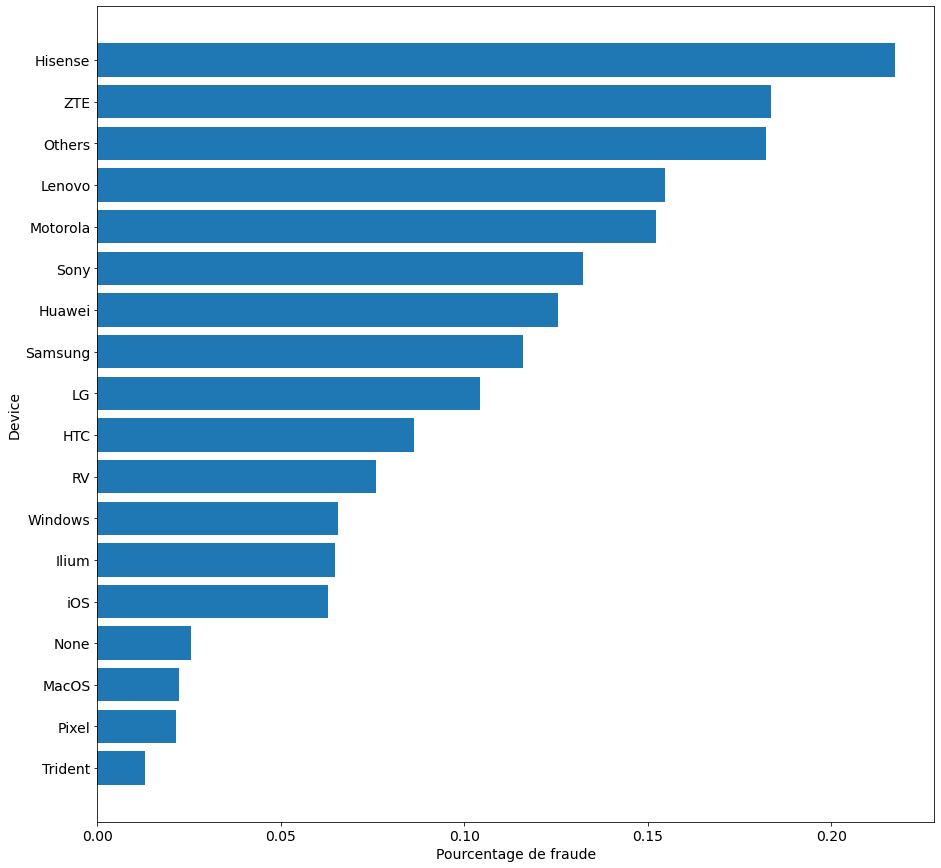

In [20]:
fraud_graph(train_df, "device_name", "Device")

Text(0, 0.5, 'id_31')

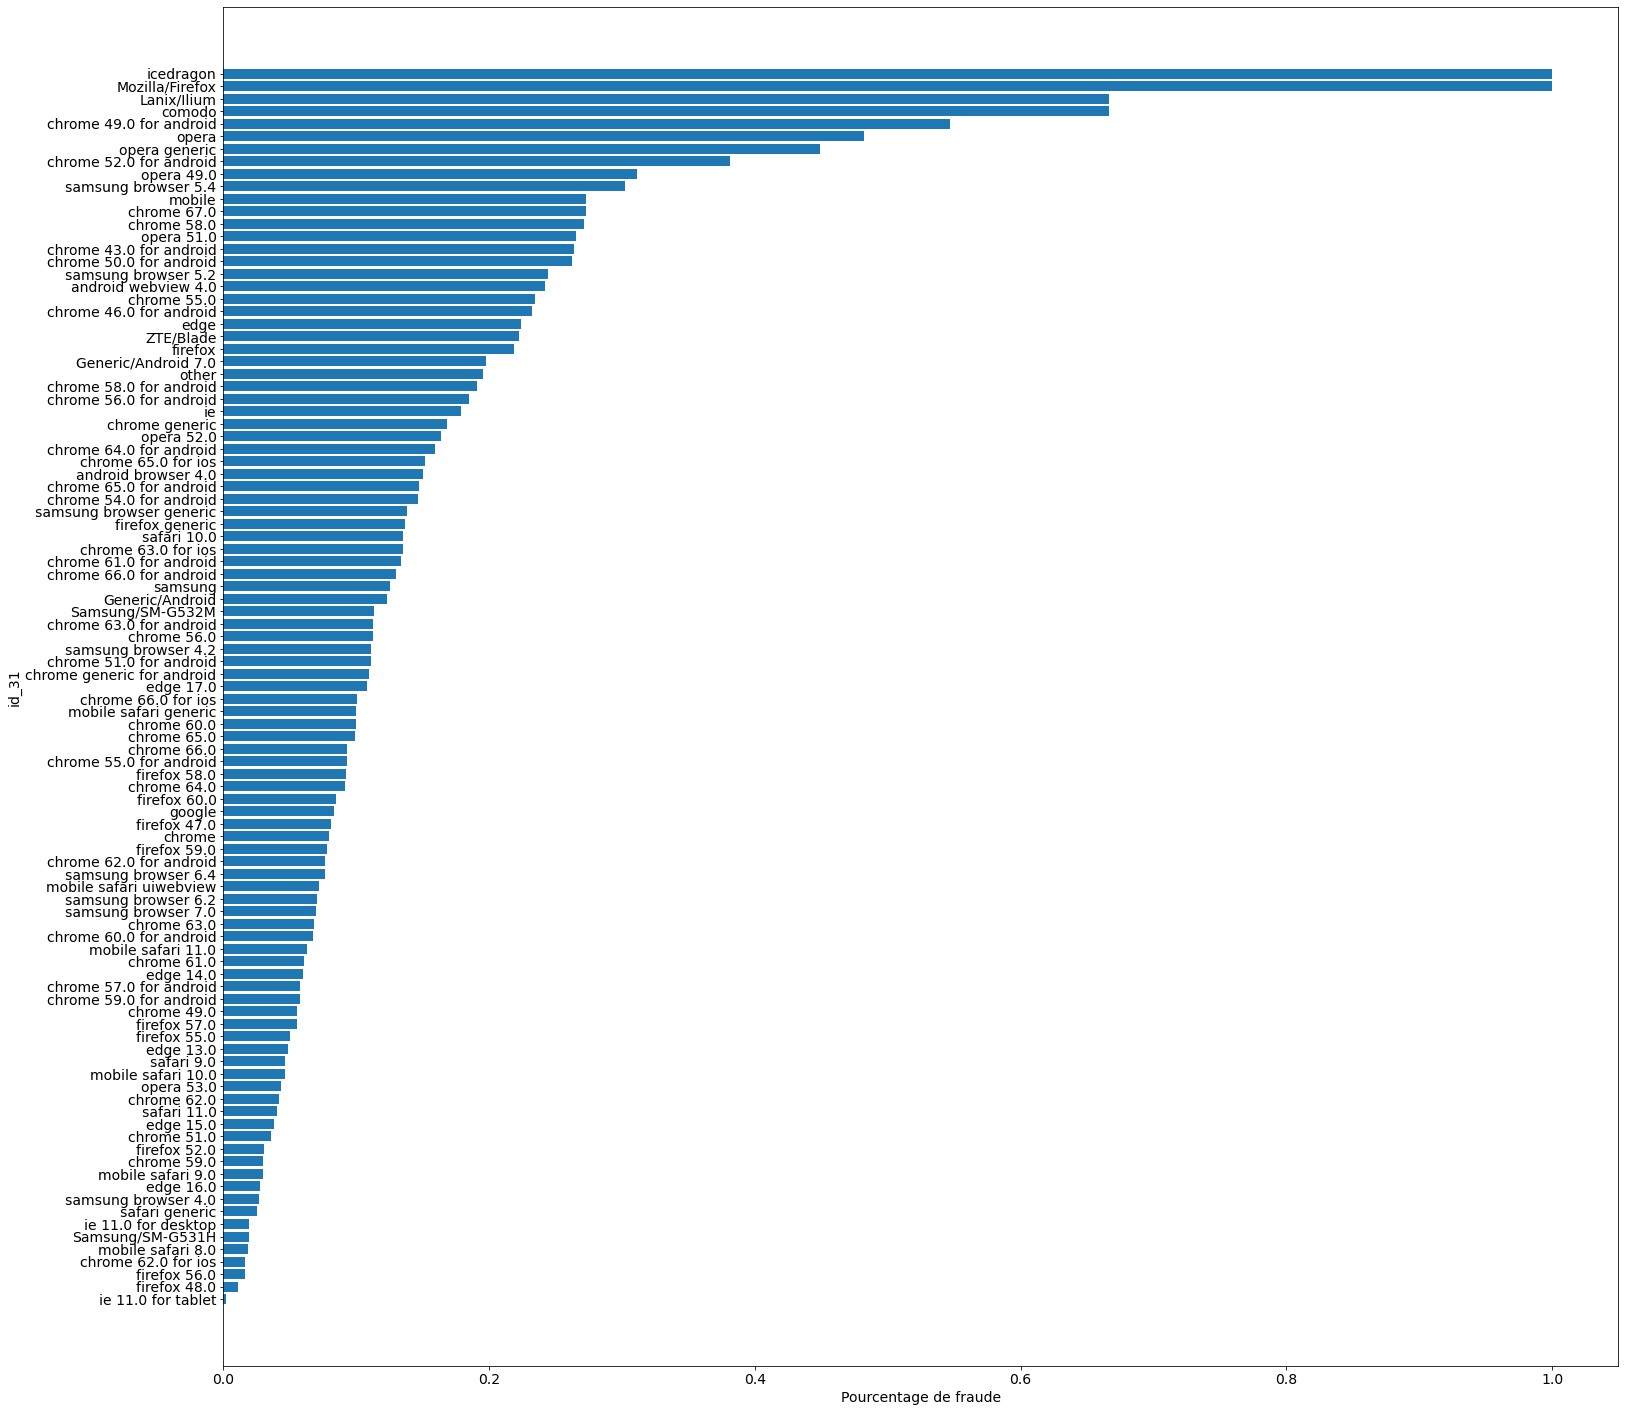

In [36]:
f, ax = plt.subplots(figsize=(25, 25))

sorted_df = train_df[["id_31", "isFraud"]].groupby(by=["id_31"]).mean().sort_values(by=["isFraud"]).iloc[31:, :]
ax.barh(y=sorted_df.index.to_numpy(), width=sorted_df["isFraud"].to_numpy())
ax.set_xlabel("Pourcentage de fraude")
ax.set_ylabel("id_31")